<a href="https://colab.research.google.com/github/rufous86/studies/blob/main/spark_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем необходимые наборы данных с kaggle  
инструкция по скачиванию данных в colab напрямую с kaggle ниже:  
https://www.kaggle.com/general/74235

In [1]:
! pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'riiid-test-answer-prediction'
! mkdir data
! unzip riiid-test-answer-prediction.zip -d data

Mounted at /content/drive
 99% 1.28G/1.29G [00:08<00:00, 169MB/s]
100% 1.29G/1.29G [00:08<00:00, 157MB/s]
Archive:  riiid-test-answer-prediction.zip
  inflating: data/example_sample_submission.csv  
  inflating: data/example_test.csv   
  inflating: data/lectures.csv       
  inflating: data/questions.csv      
  inflating: data/riiideducation/__init__.py  
  inflating: data/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: data/train.csv          


In [2]:
! pip install pyspark
! pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 55.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=b6dc268655ba01b6a209950b01ccffc304826cdf4a20445a86354541e03b0679
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark

In [9]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [49]:
df = spark.read.csv('data/train.csv', header=True, inferSchema=True)

In [50]:
df.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- content_id: integer (nullable = true)
 |-- content_type_id: integer (nullable = true)
 |-- task_container_id: integer (nullable = true)
 |-- user_answer: integer (nullable = true)
 |-- answered_correctly: integer (nullable = true)
 |-- prior_question_elapsed_time: double (nullable = true)
 |-- prior_question_had_explanation: boolean (nullable = true)



In [51]:
df.show()

+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|row_id|timestamp|user_id|content_id|content_type_id|task_container_id|user_answer|answered_correctly|prior_question_elapsed_time|prior_question_had_explanation|
+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|     0|        0|    115|      5692|              0|                1|          3|                 1|                       null|                          null|
|     1|    56943|    115|      5716|              0|                2|          2|                 1|                    37000.0|                         false|
|     2|   118363|    115|       128|              0|                0|          0|                 1|                    55000.0|                         false|
|     3|   131167|    115|  

In [52]:
from pyspark.sql.types import IntegerType

df = df.withColumn('prior_question_had_explanation', df['prior_question_had_explanation'].cast(IntegerType()))
df.show()
df.printSchema()

+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|row_id|timestamp|user_id|content_id|content_type_id|task_container_id|user_answer|answered_correctly|prior_question_elapsed_time|prior_question_had_explanation|
+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|     0|        0|    115|      5692|              0|                1|          3|                 1|                       null|                          null|
|     1|    56943|    115|      5716|              0|                2|          2|                 1|                    37000.0|                             0|
|     2|   118363|    115|       128|              0|                0|          0|                 1|                    55000.0|                             0|
|     3|   131167|    115|  

In [53]:
df.pandas_api().isna().sum()

row_id                                  0
timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

Посмотрим, сколько в нашей таблице пустых значений

In [54]:
df = df.dropna()
df.pandas_api().isna().sum()

row_id                            0
timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

Проанализируем характеристики, влияющие на успеваемость студентов. Так как фактически данные об успеваемости у нас отсутствуют, условно за успеваемость будут выступать правильно данные ответы.      
Сначала сохраним колонку answered_correctly в переменную target. Это будет наша целевая переменная  
Затем рассчитаем коэффициент корреляции целевой переменной с каждой из остальных характеристик

In [58]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [60]:
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

In [65]:
import pandas as pd

corr_matrix_df = pd.DataFrame(data=cor_np, columns = df.columns, index=df.columns)

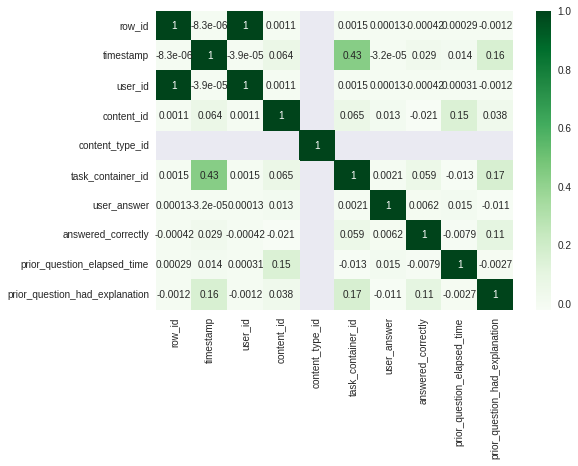

In [72]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)
plt.show()